# 1. Phân biệt giới tính dựa trên ảnh khuôn mặt

In [33]:
# Khai báo thư viện
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import matplotlib.pyplot as plt

from sklearn import linear_model           # for logistic regression
from sklearn.metrics import accuracy_score # for evaluation
from scipy import misc                     # for loading image
np.random.seed(1)                          # for fixing random values

### Data

In [34]:
# Phân chia training set và test set, lựa chọn các views
path = './data/AR_warp/' # path to the database 
train_ids = np.arange(1, 26)
test_ids = np.arange(26, 50)
view_ids = np.hstack((np.arange(1, 8), np.arange(14, 21)))

In [35]:
# Tạo random projection matrix
D = 165*120 # original dimension 
d = 500 # new dimension 

# generate the projection matrix 
ProjectionMatrix = np.random.randn(D, d)

In [36]:
# Xây dựng danh sách các tên files.
def build_list_fn(pre, img_ids, view_ids):
    """
    INPUT:
        pre = 'M-' or 'W-'
        img_ids: indexes of images
        view_ids: indexes of views
    OUTPUT:
        a list of filenames 
    """
    list_fn = []
    for im_id in img_ids:
        for v_id in view_ids:
            fn = path + pre + str(im_id).zfill(3) + '-' + \
                str(v_id).zfill(2) + '.bmp'
            list_fn.append(fn)
    return list_fn 

### Feature Extraction

In [37]:
# Feature Extraction: Xây dựng dữ liệu cho training set và test set.
def rgb2gray(rgb):
    # Y' = 0.299 R + 0.587 G + 0.114 B 
    return rgb[:,:,0]*.299 + rgb[:, :, 1]*.587 + rgb[:, :, 2]*.114

# feature extraction 
def vectorize_img(filename):    
    # load image 
    rgb = misc.imread(filename)
    # convert to gray scale 
    gray = rgb2gray(rgb)
    # vectorization each row is a data point 
    im_vec = gray.reshape(1, D)
    return im_vec 

def build_data_matrix(img_ids, view_ids):
    total_imgs = img_ids.shape[0]*view_ids.shape[0]*2 
        
    X_full = np.zeros((total_imgs, D))
    y = np.hstack((np.zeros((total_imgs//2, )), np.ones((total_imgs//2, ))))
    
    list_fn_m = build_list_fn('M-', img_ids, view_ids)
    list_fn_w = build_list_fn('W-', img_ids, view_ids)
    list_fn = list_fn_m + list_fn_w 
    
    for i in range(len(list_fn)):
        X_full[i, :] = vectorize_img(list_fn[i])

    X = np.dot(X_full, ProjectionMatrix)
    return (X, y)

(X_train_full, y_train) = build_data_matrix(train_ids, view_ids)
x_mean = X_train_full.mean(axis = 0)
x_var  = X_train_full.var(axis = 0)

def feature_extraction(X):
    return (X - x_mean)/x_var     

X_train = feature_extraction(X_train_full)
X_train_full = None ## free this variable 

(X_test_full, y_test) = build_data_matrix(test_ids, view_ids)
X_test = feature_extraction(X_test_full)
X_test_full = None 

## Build model: Logistic regression

In [38]:
logreg = linear_model.LogisticRegression(C=1e5) # just a big number 
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print ("Accuracy: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

def feature_extraction_fn(fn):
    """
    extract feature from filename
    """
    # vectorize
    im = vectorize_img(fn)
    # project
    im1 = np.dot(im, ProjectionMatrix)
    # standardization 
    return feature_extraction(im1)

fn1 = path + 'M-036-18.bmp'
fn2 = path + 'W-045-01.bmp'
fn3 = path + 'M-048-01.bmp'
fn4 = path + 'W-027-02.bmp'

x1 = feature_extraction_fn(fn1)
p1 = logreg.predict_proba(x1)
print(p1)

x2 = feature_extraction_fn(fn2)
p2 = logreg.predict_proba(x2)
print(p2)

x3 = feature_extraction_fn(fn3)
p3 = logreg.predict_proba(x3)
print(p3)

x4 = feature_extraction_fn(fn4)
p4 = logreg.predict_proba(x4)
print(p4)

Accuracy: 90.33 %
[[0.87940218 0.12059782]]
[[0.0172217 0.9827783]]
[[0.30458761 0.69541239]]
[[0.83989242 0.16010758]]


[[0.87940218 0.12059782]]


<Figure size 432x288 with 0 Axes>

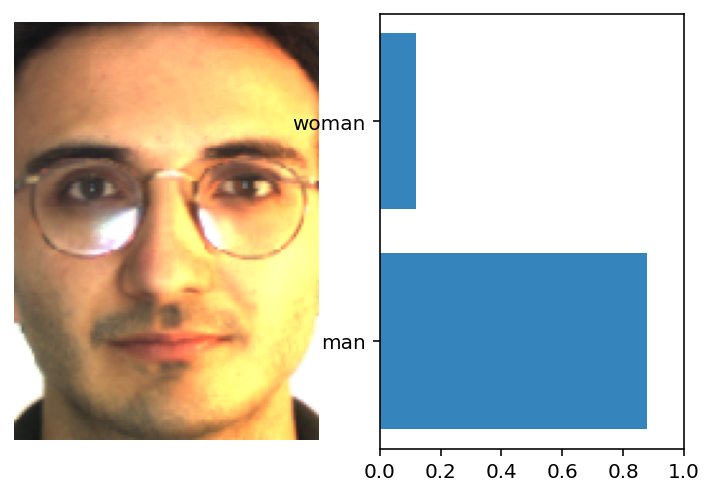

[[0.0172217 0.9827783]]


<Figure size 432x288 with 0 Axes>

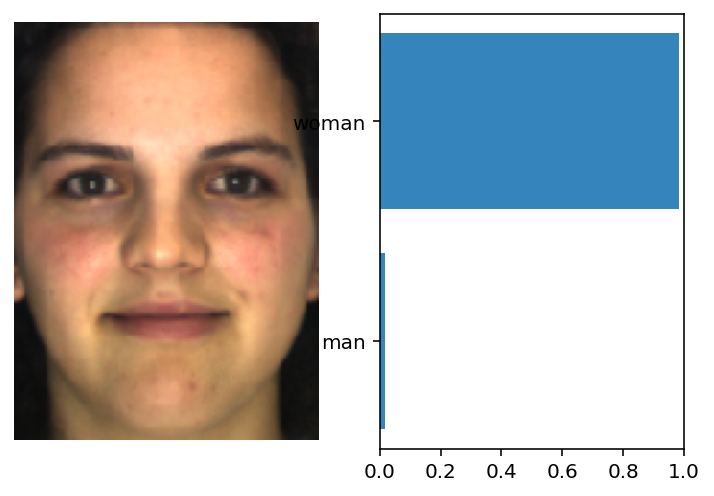

[[0.30458761 0.69541239]]


<Figure size 432x288 with 0 Axes>

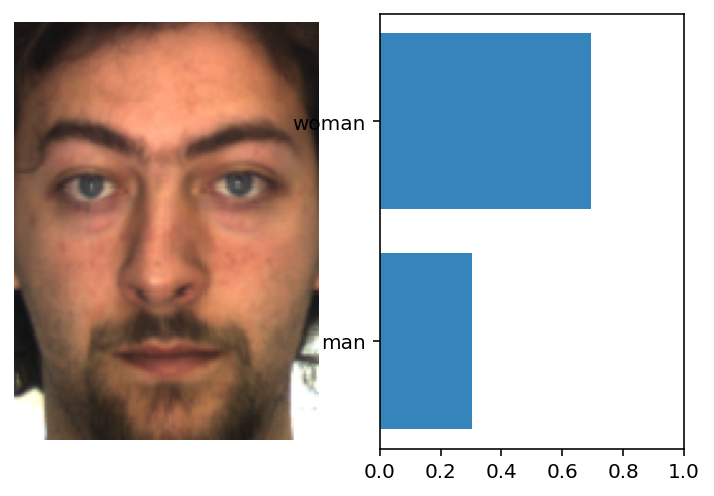

[[0.83989242 0.16010758]]


<Figure size 432x288 with 0 Axes>

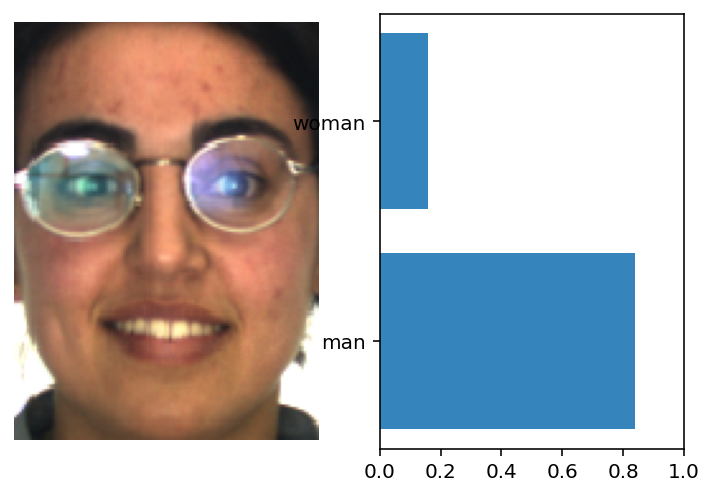

In [39]:
def display_result(fn):
    x1 = feature_extraction_fn(fn)
    p1 = logreg.predict_proba(x1)
    print(logreg.predict_proba(x1))
    rgb = misc.imread(fn)
    
    
    fig = plt.figure()
    #gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    #plt.subplot(1, 2, 1)
    plt.figure(facecolor="white")
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(rgb)
    #plt.axis('off')
    #plt.show()
    plt.subplot(122)
    plt.barh([0, 1], p1[0], align='center', alpha=0.9)
    plt.yticks([0, 1], ('man', 'woman'))
    plt.xlim([0,1])
    plt.show()
    
    
   
# load an img 
fn1 = path + 'M-036-18.bmp'
fn2 = path + 'W-045-01.bmp'
fn3 = path + 'M-048-01.bmp'
fn4 = path + 'W-027-02.bmp'
display_result(fn1)
display_result(fn2)
display_result(fn3)
display_result(fn4)